# Infomation Extraction for KTP

In [1]:
%load_ext autoreload
%autoreload 2

# Run this code cell to set notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95%; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import cv2
import copy
import glob
import json
import torch
import string
import random
import mlflow
import numpy as np
import torchmetrics
import pandas as pd
import networkx as nx
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
from datetime import datetime
from dateutil.parser import parse
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from torch.optim.lr_scheduler import CyclicLR
from torch_geometric.data import Data as G_Data
from torch_geometric.nn import GCNConv, ChebConv
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.loggers import TensorBoardLogger
from torch_geometric.data import LightningDataset as G_LightningDataset
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

random.seed(42)

In [3]:
# Set tracking URI
mlflow.set_tracking_uri(uri='http://localhost')

In [4]:
DATA_DIR = "../data/interim/2022-01-06_combined_orc_kyc"
DATA_KEY_DIR = "../data/interim/2022-01-06_combined_orc_kyc-key-fields"
DATA_VALUE_DIR = "../data/interim/2022-01-21_KTP_value_field"
TRAIN_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TRAIN"
VAL_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_VAL"
TEST_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TEST"
ANNOTATION_FILE = f"{DATA_DIR}/ktp_ground_truth.csv"
KTP_VALUE_FIELD_CLASS_FILE = f"{DATA_VALUE_DIR}/classes.txt"
RESIZE=(512, 256)
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
LOG_PATH = '../logs'
VERBOSE = True
MODEL_DIR = '../runs'
MODEL_SAVED_PATH = '../runs/models'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
with open(KTP_VALUE_FIELD_CLASS_FILE) as f:
    lines = f.readlines()
classes = [item.strip() for item in lines]
ind_to_classes_mapping = {str(i): val for i, val in enumerate(classes)}
classes_to_ind_mapping = {val: key for key, val in ind_to_classes_mapping.items()}
print(f'Classes -> {classes}\nTotal number of classes = {len(classes)}')
print(f'Index to class mapping ->\n{ind_to_classes_mapping}')
print(f'Class to index mapping ->\n{classes_to_ind_mapping}')

Classes -> ['TEXT', 'NIK', 'NAMA', 'Tempat', 'Jenis Kelamin', 'Alamat', 'RT/RW', 'Kel/Desa', 'Kecamantan', 'Agama', 'Pekerjaan', 'Berlaku Hingga', 'Kewarganegaraan', 'Nama', 'Tgl Lahir', 'Status Perkawinan', 'Kota', 'NIk']
Total number of classes = 18
Index to class mapping ->
{'0': 'TEXT', '1': 'NIK', '2': 'NAMA', '3': 'Tempat', '4': 'Jenis Kelamin', '5': 'Alamat', '6': 'RT/RW', '7': 'Kel/Desa', '8': 'Kecamantan', '9': 'Agama', '10': 'Pekerjaan', '11': 'Berlaku Hingga', '12': 'Kewarganegaraan', '13': 'Nama', '14': 'Tgl Lahir', '15': 'Status Perkawinan', '16': 'Kota', '17': 'NIk'}
Class to index mapping ->
{'TEXT': '0', 'NIK': '1', 'NAMA': '2', 'Tempat': '3', 'Jenis Kelamin': '4', 'Alamat': '5', 'RT/RW': '6', 'Kel/Desa': '7', 'Kecamantan': '8', 'Agama': '9', 'Pekerjaan': '10', 'Berlaku Hingga': '11', 'Kewarganegaraan': '12', 'Nama': '13', 'Tgl Lahir': '14', 'Status Perkawinan': '15', 'Kota': '16', 'NIk': '17'}


In [6]:
def clean_data(path, txt_path):
    key_field_files = os.listdir(path)
    data_keys = []
    for ind, key_field_file in tqdm(enumerate(key_field_files)):
        try:
            if '.jpg' in key_field_file or '.jpeg' in key_field_file or '.png' in key_field_file or '.webp' in key_field_file:
                file_name = key_field_file.split('.')[0]
                with open(os.path.join(txt_path, file_name+'.txt')) as f:
                    lines = f.readlines()
                yolo_bbox = [item.strip() for item in lines]
                with open(os.path.join(txt_path, file_name+'.json')) as json_file:
                    data = json.load(json_file)
                image_width = data['fullTextAnnotation']['pages'][0]['width']
                image_height = data['fullTextAnnotation']['pages'][0]['height']
                x_diff, y_diff = 0, 0
                n_image_width, n_image_height = 0, 0
                for i in range(len(yolo_bbox)):
                    # Value without cropping
                    xmin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'])
                    xmax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'])
                    ymin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'])
                    ymax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'])
                    data['textAnnotations'][i]['cx'], data['textAnnotations'][i]['cy'] = (xmax + xmin) // 2, (ymax + ymin) // 2
                    # Value with cropping | google vision api
                    if i == 0:
                        x_diff, y_diff = xmin, ymin
                        n_image_width = xmax - xmin
                        n_image_height = ymax - ymin
                    top_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'] - y_diff)
                    top_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'] - y_diff)
                    bottom_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'] - y_diff)
                    bottom_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'] - y_diff)
                    data['textAnnotations'][i]['boundingPoly']['normalized_vertices'] = [
                        {'x': x, 'y': y} for x, y in [top_left, top_right, bottom_right, bottom_left]
                    ]
                    n_xmin = min(top_left[0], bottom_left[0])
                    n_xmax = max(top_right[0], bottom_right[0])
                    n_ymin = min(top_left[1], top_right[1])
                    n_ymax = max(bottom_right[1], bottom_left[1])
                    data['textAnnotations'][i]['n_cx'], data['textAnnotations'][i]['n_cy'] = (n_xmax + n_xmin) // 2, (n_ymax + n_ymin) // 2
                    data['textAnnotations'][i]['class_index'] = yolo_bbox[i].split()[0]
                    data['textAnnotations'][i]['class'] = ind_to_classes_mapping[yolo_bbox[i].split()[0]]
                    if yolo_bbox[i].split()[0] == '0':
                        data['textAnnotations'][i]['is_key'] = False
                    else:
                        data['textAnnotations'][i]['is_key'] = True
                data_keys.append(
                    {   
                        'file_name': file_name,
                        'file_path': os.path.join(path, key_field_file),
                        'image_width': image_width,
                        'image_height': image_height,
                        'normalized_image_width': n_image_width,
                        'normalized_image_height': n_image_height,
                        'data': data['textAnnotations']
                    }
                )
        except Exception as e:
            continue
    return data_keys

train_data = clean_data(TRAIN_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)
val_data = clean_data(VAL_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)
test_data = clean_data(TEST_DATA_KTP_KEY_FIELD_DIR, DATA_VALUE_DIR)

284it [00:00, 957.83it/s] 
39it [00:00, 1086.00it/s]
75it [00:00, 459.36it/s]


In [7]:
train_data[0]

{'file_name': '202106100907_0a',
 'file_path': '../data/interim/2022-01-06_combined_orc_kyc-key-fields/KTP_TRAIN/202106100907_0a.jpg',
 'image_width': 664,
 'image_height': 418,
 'normalized_image_width': 565,
 'normalized_image_height': 327,
 'data': [{'locale': 'id',
   'description': 'PROVS IAl\nKABUPAT BE Gis.\nKI\nNama\n:SYAFRIZAL\nTempit/igl Labie ADANG RIMO, e\nILAKI (AKI\nL TECAL BAR\n1002 0\nAl JAMDAN\nMANDAU\nBLAM\net Osral O\nAmat\nSta\nPelajn\nWRARVAST\nBENOKALIS\nBerlaku Hingga d-11-2017\n',
   'boundingPoly': {'vertices': [{'x': 34, 'y': 20},
     {'x': 599, 'y': 20},
     {'x': 599, 'y': 347},
     {'x': 34, 'y': 347}],
    'normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 565, 'y': 0},
     {'x': 565, 'y': 327},
     {'x': 0, 'y': 327}]},
   'cx': 316,
   'cy': 183,
   'n_cx': 282,
   'n_cy': 163,
   'class_index': '0',
   'class': 'TEXT',
   'is_key': False},
  {'description': 'PROVS',
   'boundingPoly': {'vertices': [{'x': 251, 'y': 20},
     {'x': 372, 'y': 20},
 

Text(0.5, 1.0, 'Clipped image')

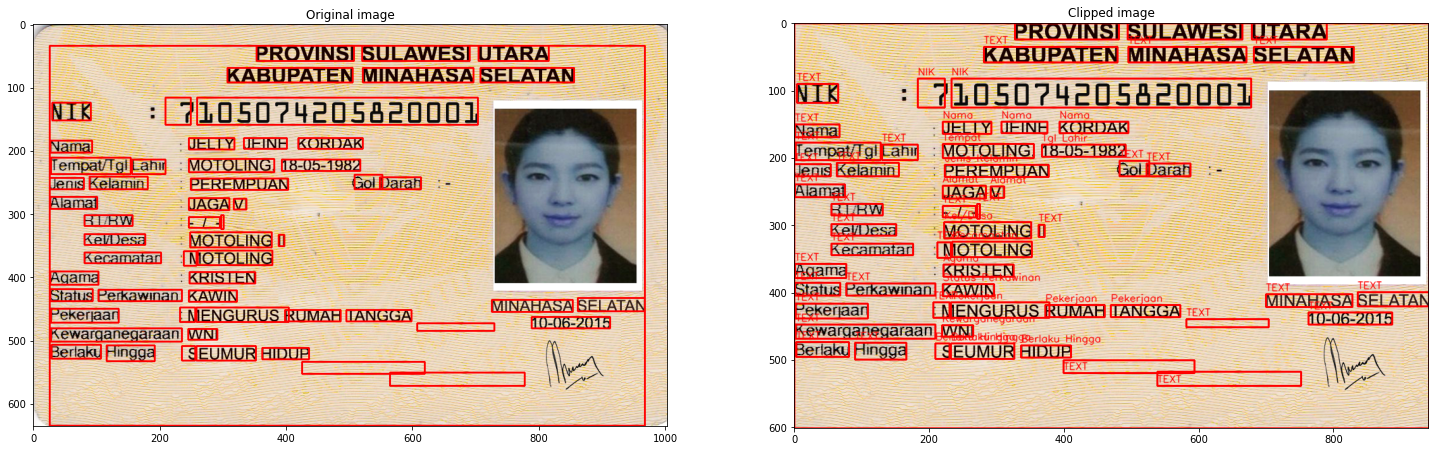

In [8]:
ind = random.randint(0, len(train_data)-1)
image = cv2.imread(train_data[ind]['file_path'])
image_copy = copy.deepcopy(image[
    train_data[ind]['data'][0]['boundingPoly']['vertices'][0]['y']
    :
    train_data[ind]['data'][0]['boundingPoly']['vertices'][2]['y'],
    train_data[ind]['data'][0]['boundingPoly']['vertices'][0]['x']
    :
    train_data[ind]['data'][0]['boundingPoly']['vertices'][2]['x'],
    :
])
for key in train_data[ind]['data']:
    image = cv2.rectangle(image, (key['boundingPoly']['vertices'][0]['x'], key['boundingPoly']['vertices'][0]['y']), (key['boundingPoly']['vertices'][2]['x'], key['boundingPoly']['vertices'][2]['y']), (255, 0, 0), 2)
    image_copy = cv2.rectangle(image_copy, (key['boundingPoly']['normalized_vertices'][0]['x'], key['boundingPoly']['normalized_vertices'][0]['y']), (key['boundingPoly']['normalized_vertices'][2]['x'], key['boundingPoly']['normalized_vertices'][2]['y']), (255, 0, 0), 2)
    image_copy = cv2.putText(image_copy, key['class'], (key['boundingPoly']['normalized_vertices'][0]['x'], key['boundingPoly']['normalized_vertices'][0]['y']-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,25))
ax1.imshow(image)
ax1.set_title("Original image")
ax2.imshow(image_copy)
ax2.set_title("Clipped image")

In [9]:
def resize_point(image_width, image_height, point, size=RESIZE):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

def get_df(raw_data):
    data_list = []
    for ind, data in tqdm(enumerate(raw_data)):
        for i, item in enumerate(data['data']):
            if i == 0:
                continue
            doc_xmin, doc_ymin = data['data'][0]['boundingPoly']['vertices'][0]['x'], data['data'][0]['boundingPoly']['vertices'][0]['y']
            doc_xmax, doc_ymax = data['data'][0]['boundingPoly']['vertices'][2]['x'], data['data'][0]['boundingPoly']['vertices'][2]['y']
            center_coords = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['n_cx'], item['n_cy']))
            x1, y1 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][0]['x'], item['boundingPoly']['normalized_vertices'][0]['y']))
            x2, y2 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][1]['x'], item['boundingPoly']['normalized_vertices'][1]['y']))
            x3, y3 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][2]['x'], item['boundingPoly']['normalized_vertices'][2]['y']))
            x4, y4 = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['boundingPoly']['normalized_vertices'][3]['x'], item['boundingPoly']['normalized_vertices'][3]['y']))
            base_data = [
                    data['file_name'],
                    data['file_path'],
                    item['description'],
                ]
            derived_data = [
                    doc_xmin, doc_ymin, doc_xmax, doc_ymax,
                    center_coords[0],
                    center_coords[1],
                    x1, y1, x2, y2, x3, y3, x4, y4,
                    center_coords[0]/RESIZE[0], 
                    center_coords[1]/RESIZE[1],
                    x1/RESIZE[0], y1/RESIZE[1], x2/RESIZE[0], y2/RESIZE[1], x3/RESIZE[0], y3/RESIZE[1], x4/RESIZE[0], y4/RESIZE[1],
                    data['normalized_image_width'],
                    data['normalized_image_height'],
                    RESIZE[0],
                    RESIZE[1]
            ]
            labels = [
                int(item['is_key']),
                int(item['class_index']),
                ind_to_classes_mapping[item['class_index']]
            ]
            data_list.append(
                base_data + derived_data + labels
            )
    return pd.DataFrame(data_list, columns=
                        ['file_name', 'file_path', 'text']
                      + ['doc_xmin', 'doc_ymin', 'doc_xmax', 'doc_ymax', 'cx', 'cy', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'n_cx', 'n_cy', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4', 'n_y4', 'n_image_width', 'n_image_height', 'resize_width', 'resize_height']
                      + ['is_key', 'raw_label', 'raw_label_name']
                    )

train_df = get_df(train_data)
val_df = get_df(val_data)
test_df = get_df(test_data)

82it [00:00, 4463.01it/s]
12it [00:00, 3691.90it/s]
22it [00:00, 4056.39it/s]


In [10]:
train_df.head()

,file_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,x1,...,n_y3,n_x4,n_y4,n_image_width,n_image_height,resize_width,resize_height,is_key,raw_label,raw_label_name
0,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVS,34,20,599,347,251.015929,9.394495,196.644248,...,0.076453,0.384071,0.076453,565,327,512,256,0,0,TEXT
1,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,IAl,34,20,599,347,338.010619,10.960245,312.637168,...,0.076453,0.610619,0.076453,565,327,512,256,0,0,TEXT
2,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,KABUPAT,34,20,599,347,221.111504,28.183486,159.490265,...,0.162080,0.311504,0.155963,565,327,512,256,0,0,TEXT
3,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,BE,34,20,599,347,304.481416,28.966361,291.794690,...,0.162080,0.569912,0.162080,565,327,512,256,0,0,TEXT
4,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,Gis.,34,20,599,347,375.164602,28.966361,335.292035,...,0.146789,0.654867,0.143731,565,327,512,256,0,0,TEXT


In [11]:
train_df['label_name'] = train_df['raw_label_name'].apply(lambda x: x.upper())
val_df['label_name'] = val_df['raw_label_name'].apply(lambda x: x.upper())
test_df['label_name'] = test_df['raw_label_name'].apply(lambda x: x.upper())

In [12]:
label_to_ind = {i: str(ind) for ind, i in enumerate(pd.concat([train_df, val_df, test_df])['label_name'].unique().tolist())}
ind_to_label = {v: k for k, v in label_to_ind.items()}

In [13]:
train_df['label'] = train_df['label_name'].apply(lambda x: int(label_to_ind[x]))
val_df['label'] = val_df['label_name'].apply(lambda x: int(label_to_ind[x]))
test_df['label'] = test_df['label_name'].apply(lambda x: int(label_to_ind[x]))
train_df.head()

,file_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,x1,...,n_y4,n_image_width,n_image_height,resize_width,resize_height,is_key,raw_label,raw_label_name,label_name,label
0,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVS,34,20,599,347,251.015929,9.394495,196.644248,...,0.076453,565,327,512,256,0,0,TEXT,TEXT,0
1,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,IAl,34,20,599,347,338.010619,10.960245,312.637168,...,0.076453,565,327,512,256,0,0,TEXT,TEXT,0
2,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,KABUPAT,34,20,599,347,221.111504,28.183486,159.490265,...,0.155963,565,327,512,256,0,0,TEXT,TEXT,0
3,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,BE,34,20,599,347,304.481416,28.966361,291.794690,...,0.162080,565,327,512,256,0,0,TEXT,TEXT,0
4,202106100907_0a,../data/interim/2022-01-06_combined_orc_kyc-ke...,Gis.,34,20,599,347,375.164602,28.966361,335.292035,...,0.143731,565,327,512,256,0,0,TEXT,TEXT,0


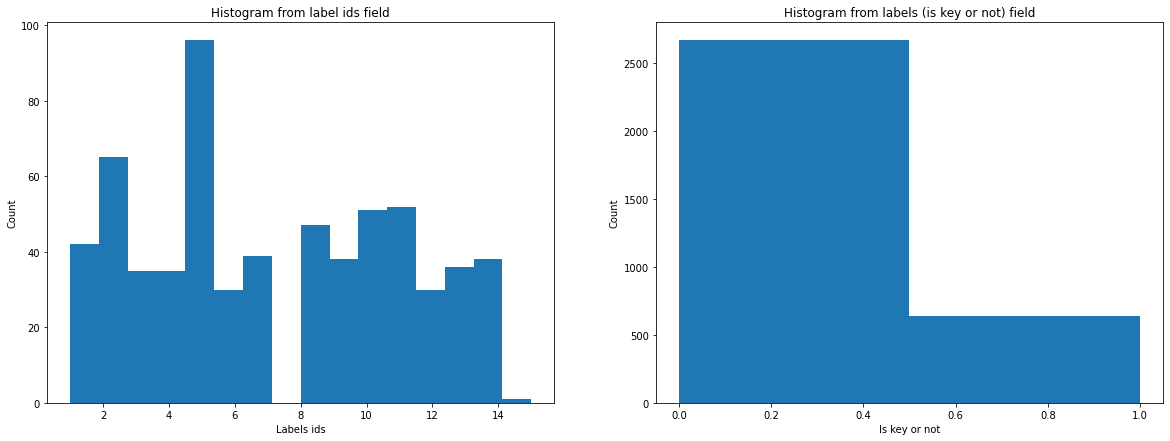

In [14]:
def plot_class_dist(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.hist(df[df['label'] !=0]['label'], bins=df['label'].nunique())
    ax1.set_title('Histogram from label ids field')
    ax1.set_xlabel('Labels ids')
    ax1.set_ylabel('Count')
    ax2.hist(df['is_key'], bins=df['is_key'].nunique())
    ax2.set_title('Histogram from labels (is key or not) field')
    ax2.set_xlabel('Is key or not')
    ax2.set_ylabel('Count')

plot_class_dist(train_df)

In [15]:
# Refer - https://github.com/dhavalpotdar/Graph-Convolution-on-Structured-Documents/blob/7400704346cb9698f6c6b1ad3307d2439d17fa33/grapher.py#L11
class Graph:
    
    def __init__(self, df, max_nodes=100, columns=['x1', 'y1', 'x3', 'y3', 'text'], label='label'):
        self.df = df
        self.df.reset_index(inplace=True)
        self.max_nodes = max_nodes
        self.xmin, self.ymin, self.xmax, self.ymax, self.text = columns
        self.label = label
        self.special_chars = {i: ind for ind, i in enumerate(string.punctuation)}
    
    def get_features(self):
        
        def is_aplha(s):
            return int(s.isalpha())

        def is_numeric(s):
            return int(s.isnumeric())

        def is_alnum(s):
            return int(s.isalnum())

        def is_decimal_number(s):
            return int(bool(re.match("[\d.\d]+$", s)))

        def is_number_with_symbols(s):
            return int(bool(re.match("[\d{}]+$".format(re.escape(string.punctuation)), s)))

        def is_date(s, fuzzy=False):
            try: 
                parse(s, fuzzy=fuzzy)
                return 1
            except (ValueError, OverflowError):
                return 0
        
        feats = []
        for ind, row in self.df.iterrows():
            is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space = 0, 0, 0, 0, 0
            is_char_special = [0] * len(self.special_chars)
            is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date = 0, 0, 0, 0, 0, 0
            for c in row['text']:
                if c.islower(): is_char_lower += 1
                if c.isupper(): is_char_upper += 1
                if c.isalpha(): is_char_alpha += 1
                if c.isnumeric(): is_char_digit += 1
                if c.isspace(): is_char_space += 1
                if c in self.special_chars.keys():
                    is_char_special[self.special_chars[c]] += 1
            for word in row['text'].split():
                is_word_alpha += is_aplha(word)
                is_word_numeric += is_numeric(word)
                is_word_alnum += is_alnum(word)
                is_word_decimal_number += is_decimal_number(word)
                is_word_number_with_symbol += is_number_with_symbols(word)
                is_word_date += is_date(word)
            feat = [is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space] + \
                   is_char_special + \
                   [is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date] + \
                   [row['n_cx'], row['n_cy'], row['n_x1'], row['n_y1'], row['n_x2'], row['n_y2'], row['n_x3'], row['n_x3'], row['n_x4'], row['n_y4']]
            feats.append(feat)
        return np.asarray(feats)
    
    def pad_adj(self, adj_matrix):
        n = adj_matrix.shape[0]
        target = np.zeros((self.max_nodes, self.max_nodes))
        if n < self.max_nodes:
            target[:n, :n] = adj_matrix
        elif n > self.max_nodes:
            target = adj_matrix[:self.max_nodes, :self.max_nodes]
        else:
            target = adj_matrix
        return target
    
    def pad_feats(self, feats):
        target = np.zeros((self.max_nodes, feats.shape[1]))
        if feats.shape[0] < self.max_nodes:
            target[:feats.shape[0], :feats.shape[1]] = feats
        elif feats.shape[0] > self.max_nodes:
            target = feats[:self.max_nodes, :feats.shape[1]]
        else:
            target = feats
        return feats
    
    def get_edge_index(self):
        edge_index = []
        node_index = self.df.index.to_list()
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_ids'] in node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['vertically_close_object_ids'])])
                edge_index.append([node_index.index(row['vertically_close_object_ids']), node_index.index(ind)])
            if row['horizontally_close_object_ids'] in  node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['horizontally_close_object_ids'])])
                edge_index.append([node_index.index(row['horizontally_close_object_ids']), node_index.index(ind)])
        return np.asarray(edge_index).T
    
    def get_goemetric_data(self, index, features):
        return G_Data(x=torch.from_numpy(features).float().contiguous(), edge_index=torch.from_numpy(index).type(torch.LongTensor).contiguous(), y=torch.Tensor(self.df[self.label].to_list()).type(torch.LongTensor).contiguous())
        
    def make_graph(self):
        graph = nx.from_dict_of_lists(self.graph_dict)
        adj_matrix_sparse = nx.adjacency_matrix(graph)
        adj_matrix = np.asarray(adj_matrix_sparse.todense())
        padded_adj_matrix = self.pad_adj(adj_matrix)
        feats = self.get_features()
        padded_feats = self.pad_feats(feats)
        edge_index = self.get_edge_index()
        data = self.get_goemetric_data(edge_index, feats)
        return graph, padded_adj_matrix, padded_feats, adj_matrix, edge_index, feats, data
         
    def generate(self):
        distances_vertical, distances_horizontal = [], []
        nearest_dst_ids_vertical, nearest_dst_ids_horizontal = [], []
        x_src_coord_vertical, y_src_coord_vertical, x_dst_coord_vertical, y_dst_coord_vertical = [], [], [], []
        x_src_coord_horizontal, y_src_coord_horizontal, x_dst_coord_horizontal, y_dst_coord_horizontal = [], [], [], []
        for src_ind, src_row in self.df.iterrows():
            dst_attributes_vertical, dst_attributes_horizontal = [], []
            src_x_range = (src_row[self.xmin], src_row[self.xmax])
            src_y_range = (src_row[self.ymin], src_row[self.ymax])
            src_centroid_x = (src_x_range[0] + src_x_range[1]) / 2
            src_centroid_y = (src_y_range[0] + src_y_range[1]) / 2
            for dst_ind, dst_row in self.df.iterrows():
                dst_x_range = (dst_row[self.xmin], dst_row[self.xmax])
                dst_y_range = (dst_row[self.ymin], dst_row[self.ymax])
                dst_centroid_x = (dst_x_range[0] + dst_x_range[1]) / 2
                dst_centroid_y = (dst_y_range[0] + dst_y_range[1]) / 2
                if src_ind != dst_ind:
                    if dst_centroid_y > src_centroid_y:
                        if dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (src_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (dst_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (src_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[0] <= src_x_range[1] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (dst_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                if dst_centroid_x > src_centroid_x:
                    if dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + src_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (dst_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[0] <= src_y_range[1] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
            dst_attributes_vertical_sorted, dst_attributes_horizontal_sorted = sorted(dst_attributes_vertical, key=lambda x: x[3]), sorted(dst_attributes_horizontal, key=lambda x: x[3])
            if len(dst_attributes_vertical_sorted) == 0:
                nearest_dst_ids_vertical.append(-1)
                x_src_coord_vertical.append(-1)
                y_src_coord_vertical.append(-1)
                x_dst_coord_vertical.append(-1)
                y_dst_coord_vertical.append(-1)
                distances_vertical.append(-1)
            else:
                nearest_dst_ids_vertical.append(dst_attributes_vertical_sorted[0][0])
                x_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][0])
                y_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][1])
                x_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][0])
                y_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][1])
                distances_vertical.append(dst_attributes_vertical_sorted[0][3])
            if len(dst_attributes_horizontal_sorted) == 0:
                nearest_dst_ids_horizontal.append(-1)
                x_src_coord_horizontal.append(-1)
                y_src_coord_horizontal.append(-1)
                x_dst_coord_horizontal.append(-1)
                y_dst_coord_horizontal.append(-1)
                
                distances_horizontal.append(-1)
            else:
                nearest_dst_ids_horizontal.append(dst_attributes_horizontal_sorted[0][0])
                x_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][0])
                y_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][1])
                x_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][0])
                y_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][1])
                distances_horizontal.append(dst_attributes_horizontal_sorted[0][3])
        vertically_close_objects, horizontally_close_objects = [], []
        for i in nearest_dst_ids_vertical:
            if i == -1:
                vertically_close_objects.append('')
            else:
                vertically_close_objects.append(self.df.loc[i, 'text'])
        for i in nearest_dst_ids_horizontal:
            if i == -1:
                horizontally_close_objects.append('')
            else:
                horizontally_close_objects.append(self.df.loc[i, 'text'])
        self.df['vertically_close_objects'] = vertically_close_objects
        self.df['vertically_close_object_ids'] = nearest_dst_ids_vertical
        self.df['vertically_close_object_x_src_coord_centroid'] = x_src_coord_vertical
        self.df['vertically_close_object_y_src_coord_centroid'] = y_src_coord_vertical
        self.df['vertically_close_object_x_dst_coord_centroid'] = x_dst_coord_vertical
        self.df['vertically_close_object_y_dst_coord_centroid'] = y_dst_coord_vertical
        self.df['vertically_close_object_distances'] = distances_vertical
        self.df['horizontally_close_objects'] = horizontally_close_objects
        self.df['horizontally_close_object_ids'] = nearest_dst_ids_horizontal
        self.df['horizontally_close_object_x_src_coord_centroid'] = x_src_coord_horizontal
        self.df['horizontally_close_object_y_src_coord_centroid'] = y_src_coord_horizontal
        self.df['horizontally_close_object_x_dst_coord_centroid'] = x_dst_coord_horizontal
        self.df['horizontally_close_object_y_dst_coord_centroid'] = y_dst_coord_horizontal
        self.df['horizontally_close_object_distances'] = distances_horizontal
        grouped_vertical = self.df.groupby('vertically_close_object_ids')['vertically_close_object_distances'].min()
        grouped_horizontal = self.df.groupby('horizontally_close_object_ids')['horizontally_close_object_distances'].min()
        grouped_vertical_dict = dict(zip(grouped_vertical.index, grouped_vertical.values))
        grouped_horizontal_dict = dict(zip(grouped_horizontal.index, grouped_horizontal.values))
        for ind, row in self.df.iterrows():
            vertically_close_object_id = row['vertically_close_object_ids']
            horizontally_close_object_id = row['horizontally_close_object_ids']
            if row['vertically_close_object_distances'] > grouped_vertical_dict[vertically_close_object_id]:
                row['vertically_close_object_x_src_coord_centroid'] = row['vertically_close_object_y_src_coord_centroid'] = \
                row['vertically_close_object_x_dst_coord_centroid'] = row['vertically_close_object_y_dst_coord_centroid'] = -1
                row['vertically_close_object_distances'] = -1
            if row['horizontally_close_object_distances'] > grouped_horizontal_dict[horizontally_close_object_id]:
                row['horizontally_close_object_x_src_coord_centroid'] = row['horizontally_close_object_y_src_coord_centroid'] = \
                row['horizontally_close_object_x_dst_coord_centroid'] = row['horizontally_close_object_y_dst_coord_centroid'] = -1
                row['horizontally_close_object_distances'] = -1
        self.graph_dict = {i: [] for i in self.df.index.to_list()}
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['vertically_close_object_ids'])
            if row['horizontally_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['horizontally_close_object_ids'])
        return self.df.drop(columns=['index'], inplace=True), self.graph_dict
    
    def graph(self):
        self.generate()
        graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data = self.make_graph()
        return self.df, self.graph_dict, graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data

In [16]:
__df__, __graph_dict__, __graph__, __padded_adj_matrix__, __padded_features__, __adj_matrix__, __edge_index__, __features__, __data__ = Graph(test_df[test_df['file_name']=='KTP20']).graph()

In [17]:
__graph_dict__

{0: [6, 1],
 1: [4, 2],
 2: [4, 3],
 3: [5],
 4: [5, 5],
 5: [6],
 6: [30],
 7: [8, 6],
 8: [9, 30],
 9: [13, 10],
 10: [14, 11],
 11: [33, 12],
 12: [34],
 13: [15, 14],
 14: [15, 33],
 15: [16, 35],
 16: [17, 40],
 17: [18, 41],
 18: [20, 19],
 19: [44],
 20: [21, 22],
 21: [25, 22],
 22: [45, 23],
 23: [45, 24],
 24: [45, 47],
 25: [26, 45],
 26: [50, 27],
 27: [50, 53],
 28: [29],
 29: [50],
 30: [11, 31],
 31: [11, 32],
 32: [12],
 33: [35, 34],
 34: [35, 42],
 35: [40, 36],
 36: [40, 37],
 37: [41, 38],
 38: [46, 39],
 39: [53],
 40: [41],
 41: [19],
 42: [38, 43],
 43: [39],
 44: [22],
 45: [26, 46],
 46: [48],
 47: [48],
 48: [49],
 49: [],
 50: [51],
 51: [52],
 52: [53],
 53: []}

In [18]:
__df__.columns

Index(['file_name', 'file_path', 'text', 'doc_xmin', 'doc_ymin', 'doc_xmax',
       'doc_ymax', 'cx', 'cy', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'n_cx', 'n_cy', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4',
       'n_y4', 'n_image_width', 'n_image_height', 'resize_width',
       'resize_height', 'is_key', 'raw_label', 'raw_label_name', 'label_name',
       'label', 'vertically_close_objects', 'vertically_close_object_ids',
       'vertically_close_object_x_src_coord_centroid',
       'vertically_close_object_y_src_coord_centroid',
       'vertically_close_object_x_dst_coord_centroid',
       'vertically_close_object_y_dst_coord_centroid',
       'vertically_close_object_distances', 'horizontally_close_objects',
       'horizontally_close_object_ids',
       'horizontally_close_object_x_src_coord_centroid',
       'horizontally_close_object_y_src_coord_centroid',
       'horizontally_close_object_x_dst_coord_centroid',
       'horizontally_close_object_y_dst_

In [19]:
__df__

,file_name,file_path,text,doc_xmin,doc_ymin,doc_xmax,doc_ymax,cx,cy,x1,...,vertically_close_object_x_dst_coord_centroid,vertically_close_object_y_dst_coord_centroid,vertically_close_object_distances,horizontally_close_objects,horizontally_close_object_ids,horizontally_close_object_x_src_coord_centroid,horizontally_close_object_y_src_coord_centroid,horizontally_close_object_x_dst_coord_centroid,horizontally_close_object_y_dst_coord_centroid,horizontally_close_object_distances
0,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,PROVINSI,12,18,886,541,120.091533,7.342256,72.054920,...,135.322654,49.682600,42.095602,DAERAH,1,120.384439,7.342256,215.871854,7.342256,95.487414
1,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,DAERAH,12,18,886,541,215.578947,7.342256,174.572082,...,224.951945,25.453155,18.110899,ISTIMEWA,2,215.871854,7.342256,313.702517,7.342256,97.830664
2,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,ISTIMEWA,12,18,886,541,313.409611,8.321224,265.372998,...,285.290618,25.453155,16.887189,YOGYAKARTA,3,313.702517,9.055449,440.530892,9.055449,126.828375
3,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,YOGYAKARTA,12,18,886,541,440.530892,9.300191,369.061785,...,384.585812,25.942639,16.642447,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,KABUPATEN,12,18,886,541,248.970252,25.453155,192.732265,...,299.350114,25.942639,0.489484,SLEMAN,5,248.970252,25.697897,346.800915,25.697897,97.830664
5,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,SLEMAN,12,18,886,541,346.800915,25.942639,293.491991,...,332.741419,49.682600,23.739962,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,:3404101607840001,12,18,886,541,236.668192,49.437859,101.931350,...,144.988558,75.380497,25.697897,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,NIK,12,18,886,541,24.604119,48.458891,3.514874,...,24.897025,74.891013,26.432122,:3404101607840001,6,24.897025,48.703633,236.961098,48.703633,212.064073
8,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,Nama,12,18,886,541,25.189931,74.891013,2.929062,...,29.583524,90.554493,15.663480,ARIF,30,25.189931,75.380497,144.988558,75.380497,119.798627
9,KTP20,../data/interim/2022-01-06_combined_orc_kyc-ke...,Tempat/1gl,12,18,886,541,46.864989,90.554493,11.716247,...,25.775744,103.281071,12.726577,Lahir,10,46.864989,90.554493,101.052632,90.554493,54.187643


In [20]:
__data__

Data(x=[54, 53], edge_index=[2, 170], y=[54])

In [21]:
__data__.y

tensor([ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  3, 13,  0,  0,  0,  0,  0,
         0,  8,  0,  0,  0, 14, 14,  0,  0, 12,  0,  0,  2,  2,  2,  4,  4,  5,
         5,  5,  5,  5,  6,  7,  0,  0,  9, 10,  0,  0,  0,  0, 11, 11, 11,  0])

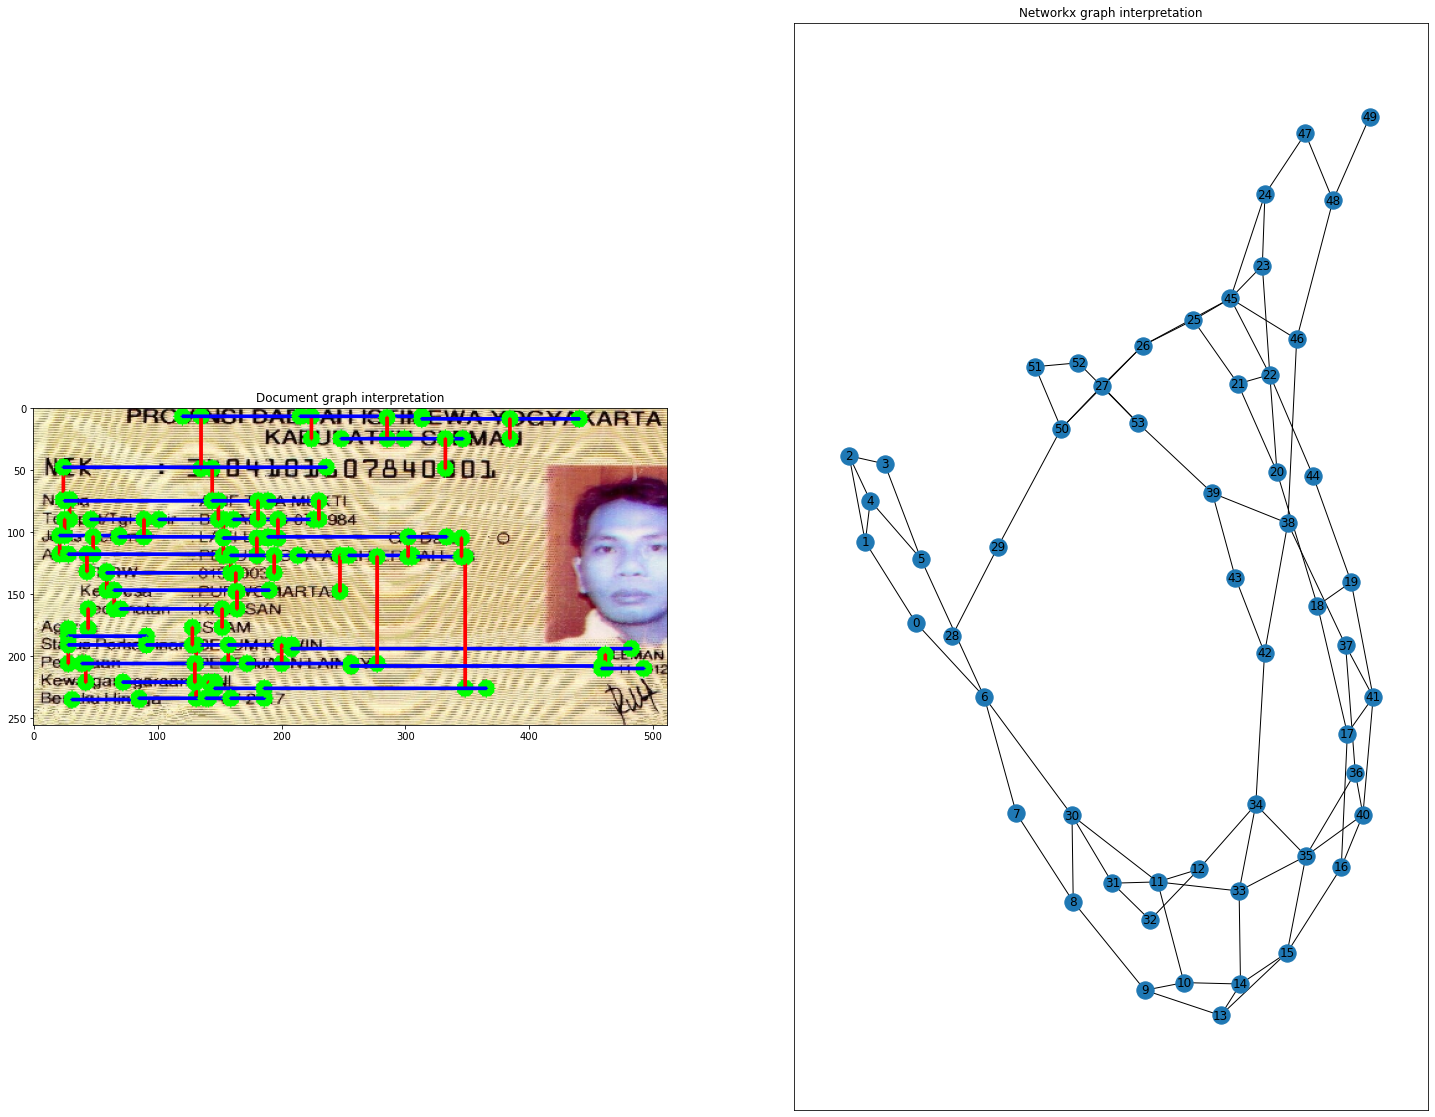

In [22]:
def plot_document_graph(df, g, resize=RESIZE):
    assert df['file_name'].nunique() == 1, 'The plot is only for one document. Pass a df corresponding to only image/txt file.'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
    file_path = df['file_path'].unique()[0]
    doc_xmin, doc_ymin, doc_xmax, doc_ymax = df['doc_xmin'].unique()[0], df['doc_ymin'].unique()[0], df['doc_xmax'].unique()[0], df['doc_ymax'].unique()[0]
    image = cv2.imread(file_path)
    image = image[doc_ymin: doc_ymax, doc_xmin: doc_xmax, :]
    image = cv2.resize(image, resize)
    for ind, row in df.iterrows():
        if row['vertically_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), color=(255, 0, 0), thickness=2)
        if row['horizontally_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), color=(0, 0, 255), thickness=2)
    ax1.imshow(image)
    ax1.set_title('Document graph interpretation')
    ax2.set_title('Networkx graph interpretation')
    nx.draw_networkx(g, ax=ax2)

plot_document_graph(__df__, __graph__)

In [23]:
label_to_ind

{'TEXT': '0',
 'NIK': '1',
 'NAMA': '2',
 'TEMPAT': '3',
 'JENIS KELAMIN': '4',
 'ALAMAT': '5',
 'RT/RW': '6',
 'KEL/DESA': '7',
 'KECAMANTAN': '8',
 'AGAMA': '9',
 'PEKERJAAN': '10',
 'BERLAKU HINGGA': '11',
 'KEWARGANEGARAAN': '12',
 'TGL LAHIR': '13',
 'STATUS PERKAWINAN': '14',
 'KOTA': '15'}

In [27]:
overfit_df = test_df[test_df['label'] != 0]

In [25]:
ce_weights = np.asarray([1 - (i / len(val_df)) for i in list(val_df['label'].value_counts().sort_index()) + [0]])
ce_weights

array([0.29304029, 0.98534799, 0.96336996, 0.97802198, 0.98168498,
       0.95238095, 0.98351648, 0.98168498, 0.98534799, 0.98351648,
       0.98168498, 0.97802198, 0.98351648, 0.98534799, 0.98351648,
       1.        ])

In [28]:
def plot_graph(g, ind):
    figure = plt.figure(figsize=(15, 15))
    plt.title(f'Graph for data point at index {ind}')
    nx.draw_networkx(g)
    
def create_graph_dataset(df):
    graphs, dataset = [], []
    docs = list(df['file_name'].unique())
    for doc in tqdm(docs):
        _, _, graph, _, _, _, _, _, data = Graph(df[df['file_name']==doc]).graph()
        if len(data.edge_index.shape) == 2:
            graphs.append(graph)
            dataset.append(data)
    return graphs, dataset

train_graphs, train_dataset = create_graph_dataset(train_df)
val_graphs, val_dataset = create_graph_dataset(val_df)
test_graphs, test_dataset = create_graph_dataset(test_df)
overfit_graphs, overfit_dataset = create_graph_dataset(overfit_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.01it/s]


Count of valid and cleaned data = 12


Data(x=[3, 53], edge_index=[2, 4], y=[3])

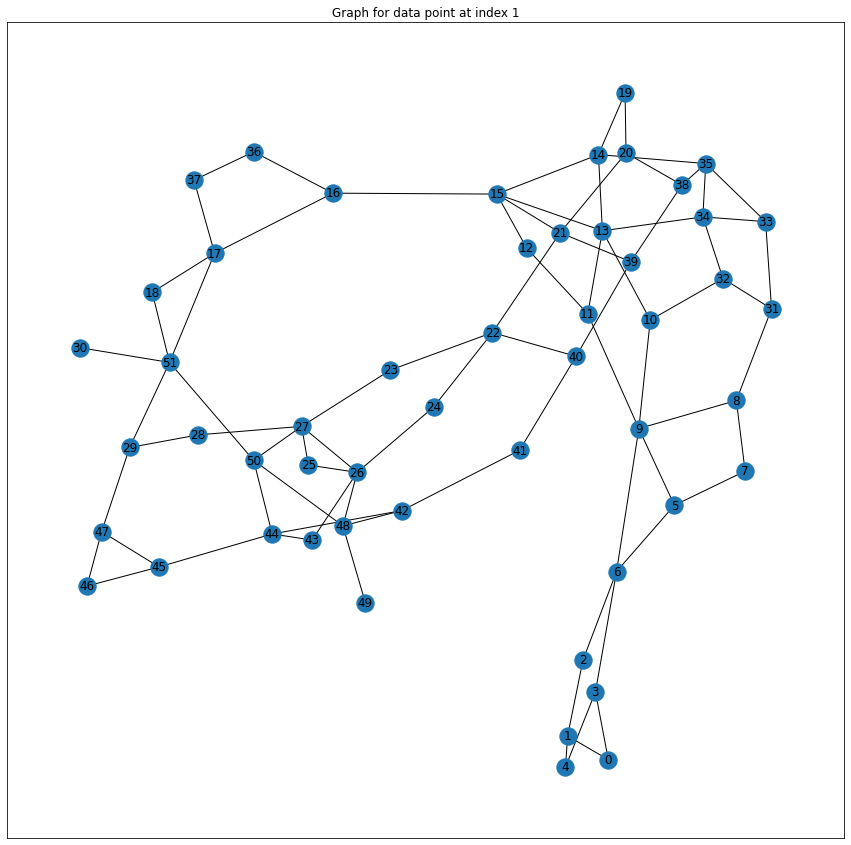

In [29]:
ind = random.choice(np.arange(0, len(val_dataset)))
plot_graph(train_graphs[ind], ind)
print('Count of valid and cleaned data =', len(val_dataset))
val_dataset[ind]

In [49]:
val_dataset[1].y

tensor([0, 0, 0])

In [50]:
data_module = G_LightningDataset(val_dataset[0: 2], val_dataset[0: 2], val_dataset[0: 2], BATCH_SIZE)

In [51]:
data_module.train_dataset

[Data(x=[51, 53], edge_index=[2, 136], y=[51]),
 Data(x=[3, 53], edge_index=[2, 4], y=[3])]

In [42]:
def visualize_tsne(h, color, n_components=2):
    if isinstance(h, np.ndarray):
        z = TSNE(n_components=n_components).fit_transform(h)
    else:
        z = TSNE(n_components=n_components).fit_transform(h.detach().cpu().numpy())       
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('TSNE for GCN output')
    plt.scatter(z[:, 0], z[:, 1], s=75, c=color, cmap='Set1')
    plt.show()

In [43]:
class GCN(torch.nn.Module):
    
    def __init__(self, num_features, num_classes, is_spectral=False, K=3, dropout=0.2, torch_seed=42):
        super().__init__()
        torch.manual_seed(torch_seed)
        self.dropout=dropout
        if is_spectral:
            self.conv1 = ChebConv(num_features, 32, K=K)
            self.conv2 = ChebConv(32, 16, K=K)
            self.conv3 = ChebConv(16, num_classes, K=K)
        else:
            self.conv1 = GCNConv(num_features, 32, improved=True)
            self.conv2 = GCNConv(32, 16, improved=True)
            self.conv3 = GCNConv(16, num_classes, improved=True)

    def forward(self, x, edge_index):
        x = F.dropout(self.conv1(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.dropout(self.conv2(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.log_softmax(self.conv3(x, edge_index), dim=1)
        return x

GCN(
  (conv1): GCNConv(53, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 16)
)
Model output shape =  torch.Size([54, 16])


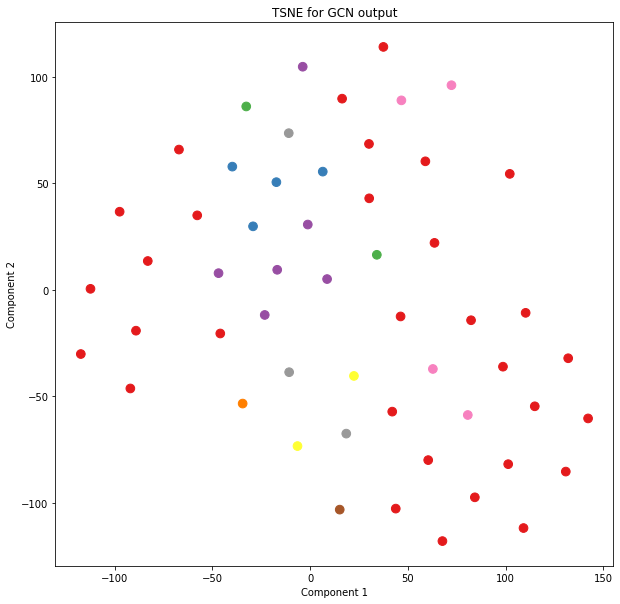

In [44]:
__model__ = GCN(num_features=53, num_classes=len(label_to_ind))
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

GCN(
  (conv1): ChebConv(53, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 16, K=3, normalization=sym)
  (conv3): ChebConv(16, 16, K=3, normalization=sym)
)
Model output shape =  torch.Size([54, 16])


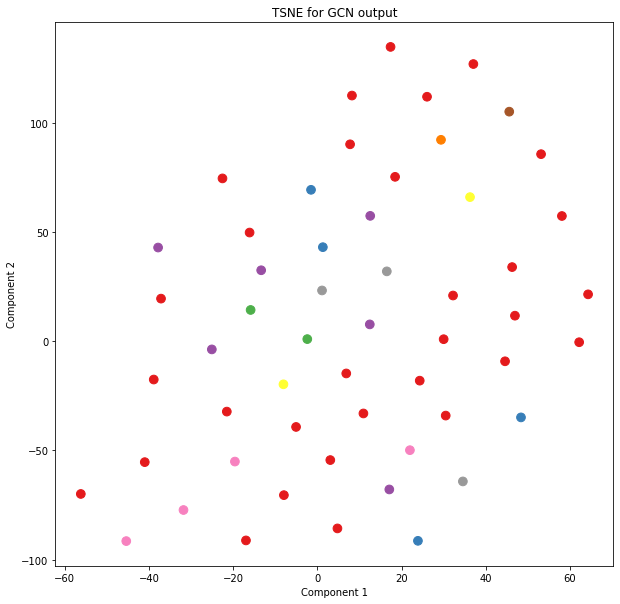

In [45]:
__model__ = GCN(num_features=53, num_classes=len(label_to_ind), is_spectral=True)
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

In [46]:
class LitGCN(pl.LightningModule):

    def __init__(self, ce_weights, is_spectral=False, num_features=53, num_classes=len(label_to_ind), batch_size=32, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.ce_weights = ce_weights
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = GCN(num_features=num_features, num_classes=num_classes, is_spectral=is_spectral)
        self.learning_rate=learning_rate
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def training_step(self, train_batch, batch_idx):
        data = train_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitGCN(ce_weights=self.ce_weights), [torch.randn((69, 53)), torch.randint(0, 69, (2, 100)).type(torch.LongTensor)])
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        data = val_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        data = test_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

In [63]:
def test_model(ckpt, ce_weights, demo_data, is_spectral=False):
    model = LitGCN.load_from_checkpoint(checkpoint_path=ckpt, ce_weights=ce_weights, is_spectral=is_spectral)
    model.eval()
    out = model(demo_data.x, demo_data.edge_index)
    print('Model output shape = ', out.size())
    visualize_tsne(out, color=demo_data.y)
    df_model_res = {
        'pred_label': [],
        'true_label': []
    }
    for test_data in val_dataset[0: 2]:
        y_hat = model(test_data.x, test_data.edge_index)
        y_hat = y_hat.cpu().detach().numpy()
        y_hat = np.argmax(y_hat, axis=1)
        y = test_data.y.cpu().detach().numpy()
        for i in range(len(y)):
            df_model_res['pred_label'].append(y_hat[i])
            df_model_res['true_label'].append(y[i])
    df_model_res = pd.DataFrame.from_dict(df_model_res)
    print(df_model_res['pred_label'].unique())
    print(df_model_res['true_label'].unique())
    print(classification_report(df_model_res['pred_label'], df_model_res['true_label']))
    return df_model_res

## Spatial GCN

In [52]:
%%time
# mlflow.pytorch.autolog()
trainer_spatial = pl.Trainer(default_root_dir='../logs',
                               precision=32,
                               limit_train_batches=0.5,
                               gpus=1 if torch.cuda.is_available() else None, 
                               max_epochs=250,
                               logger=TensorBoardLogger('../logs', name='2022-01-06_combined_orc_kyc-key-fields-order-spatial-gcn'),
                               callbacks=[
                                      LearningRateMonitor(logging_interval="step"), 
                                      ModelCheckpoint(monitor="train_loss"),
                                  ],
#                              resume_from_checkpoint='../logs' + '/' +'key_model' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                               )

# with mlflow.start_run(run_name=SPATIAL_EXPERIMENT_NAME + ' ' + datetime.now().strftime('%d-%m-%Y %H:%M'), tags={'time': datetime.now().strftime('%d-%m-%Y %H:%M')}) as run:
trainer_spatial.fit(LitGCN(ce_weights), data_module)
trainer_spatial.test(ckpt_path="best", datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | Accuracy         | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | model     | GCN              | 2.5 K 
-----------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2022-02-07 14:44:00.081201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-07 14:44:00.081226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
Restoring states from the checkpoint path at ../logs/2022-01-06_combined_orc_kyc-key-fields-order-spatial-gcn/versi

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7941176891326904, 'test_loss': 1.1265385150909424}
--------------------------------------------------------------------------------
CPU times: user 40.9 s, sys: 876 ms, total: 41.7 s
Wall time: 15.1 s


[{'test_loss': 1.1265385150909424, 'test_acc': 0.7941176891326904}]

In [53]:
%%time
trainer_spatial.test(ckpt_path="best", datamodule=data_module)

/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
Restoring states from the checkpoint path at ../logs/2022-01-06_combined_orc_kyc-key-fields-order-spatial-gcn/version_1/checkpoints/epoch=222-step=222.ckpt
Loaded model weights from checkpoint at ../logs/2022-01-06_combined_orc_kyc-key-fields-order-spatial-gcn/version_1/checkpoints/epoch=222-step=222.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7941176891326904, 'test_loss': 1.1265385150909424}
--------------------------------------------------------------------------------
CPU times: user 98.2 ms, sys: 0 ns, total: 98.2 ms
Wall time: 52.5 ms


/home/tyche/miniconda3/envs/insureka/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


[{'test_loss': 1.1265385150909424, 'test_acc': 0.7941176891326904}]

Model output shape =  torch.Size([54, 16])


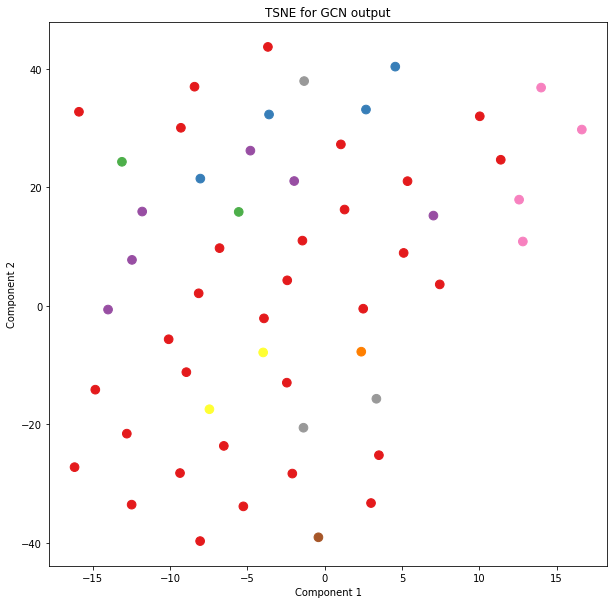

[0 5]
[ 0  1  2  3 13  4  5  6  7  8  9 14 12 10 11]
              precision    recall  f1-score   support

           0       1.00      0.63      0.77        46
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.50      0.50      0.50         8
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.61        54
   macro avg       0.10    

In [64]:
res_spatial = test_model(trainer_spatial.checkpoint_callbacks[0].best_model_path, ce_weights, __data__)

In [65]:
res_spatial['pred_label'].value_counts()

0    46
5     8
Name: pred_label, dtype: int64

In [66]:
res_spatial['true_label'].value_counts()

0     29
5      8
2      3
6      2
9      2
1      1
3      1
13     1
4      1
7      1
8      1
14     1
12     1
10     1
11     1
Name: true_label, dtype: int64

In [67]:
def plot_record_inf(df, resize=RESIZE):
    assert len(df['file_name'].unique().tolist()) == 1, 'df must have only one document.'
    image = cv2.imread(df.iloc[0]['file_path'])
    image = image[df.iloc[0]['doc_ymin']: df.iloc[0]['doc_ymax'], df.iloc[0]['doc_xmin']: df.iloc[0]['doc_xmax'], :]
    image = cv2.resize(image, resize)
    for ind, row in df.iterrows():
        if row['label_pred'] != int(classes_to_ind_mapping['TEXT']):
            image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 1)
            image = cv2.putText(image, row['label_names_pred'][:5], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (255, 0, 0), 1, cv2.LINE_AA)       
    fig = plt.figure(figsize=(30,15))
    plt.imshow(image)

def inference( model, df=None, data=None, verbose=True):
    model.eval()
    if not data:
        inf_df = copy.deepcopy(df)
        inf_df, graph_dict, graph, padded_adj_matrix, padded_features, adj_matrix, edge_index, features, data = Graph(inf_df).graph()
    else:
        inf_df = pd.DataFrame()
    y_hat = model(data.x, data.edge_index)
    y_hat = y_hat.cpu().detach().numpy()
    out = copy.deepcopy(y_hat)
    y = data.y.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    if not data:
        inf_df['label_pred'] = list(y_hat)
        inf_df['label_names_pred'] = inf_df['label_pred'].apply(lambda x: ind_to_classes_mapping[str(x)])
        inf_df['label_names'] = inf_df['label'].apply(lambda x: ind_to_classes_mapping[str(x)])
    else:
        inf_df['label'] = list(y)
        inf_df['label_pred'] = list(y_hat)
        inf_df['label_names_pred'] = inf_df['label_pred'].apply(lambda x: ind_to_classes_mapping[str(x)])
        inf_df['label_names'] = inf_df['label'].apply(lambda x: ind_to_classes_mapping[str(x)])
    if verbose:
        visualize_tsne(out, y_hat)
        if df:
            plot_document_graph(inf_df, graph)
            plot_record_inf(inf_df)
    return inf_df

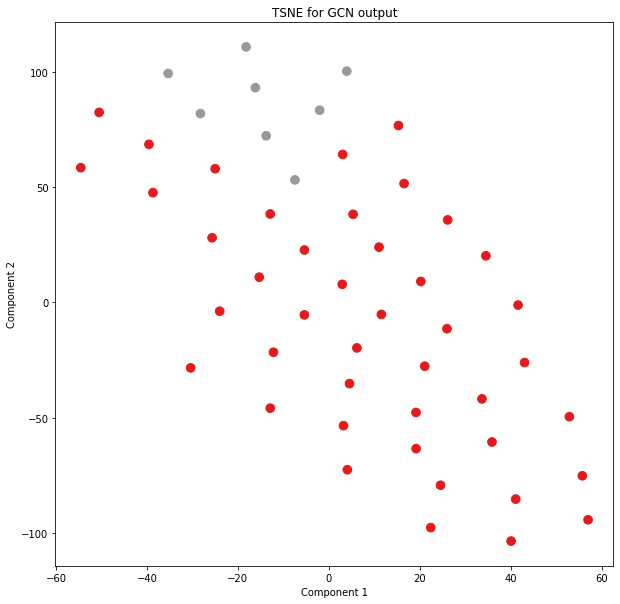

In [68]:
test_df_record = test_df[test_df['file_name'] == random.choice(test_df['file_name'].unique().tolist())]
res = inference(LitGCN.load_from_checkpoint(checkpoint_path=trainer_spatial.checkpoint_callbacks[0].best_model_path, ce_weights=ce_weights), data=val_dataset[0])